In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 64
batch_size = 64
num_points = 128
num_samples = 20000
n_epochs = 10


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(num_points-50, num_points-50))


def get_model(x_dim, y_dim):
    return NeuralProcess(x_dim, y_dim,
                         XYEncoder=_DeepMLP,
                         Decoder=_DeepMLP,
                         r_dim=r_dim,
                         LatentEncoder=MLP,
                         get_cntxt_trgt=get_cntxt_trgt,
                        encoded_path="latent")


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))

/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=128 and input=64. Setting it to 64.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

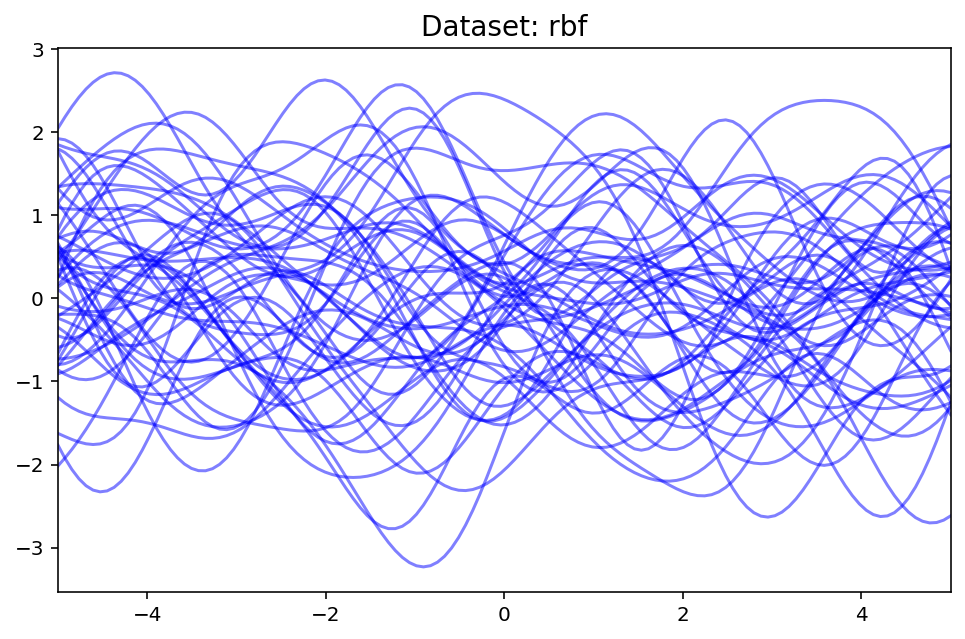

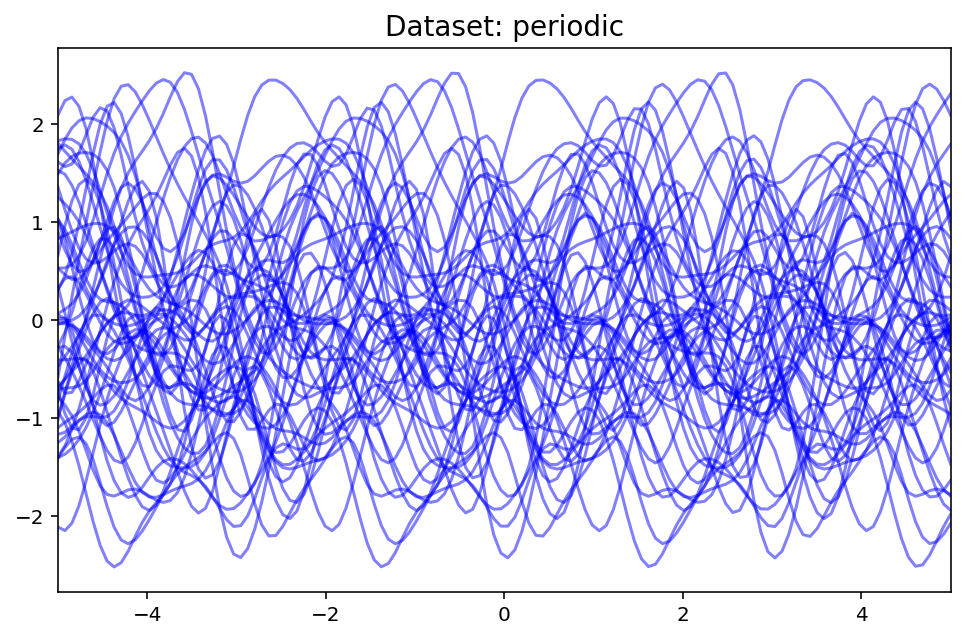

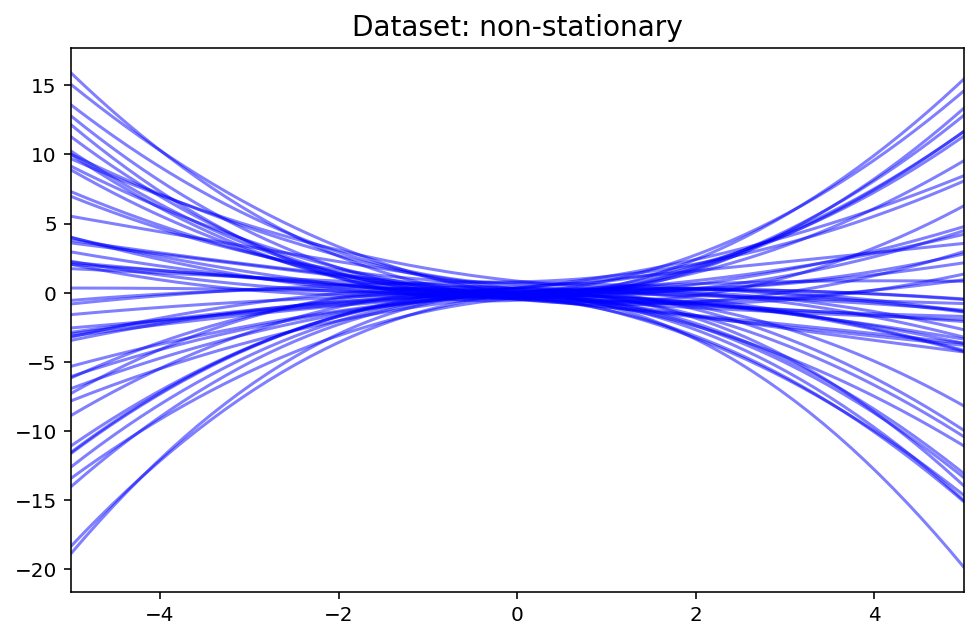

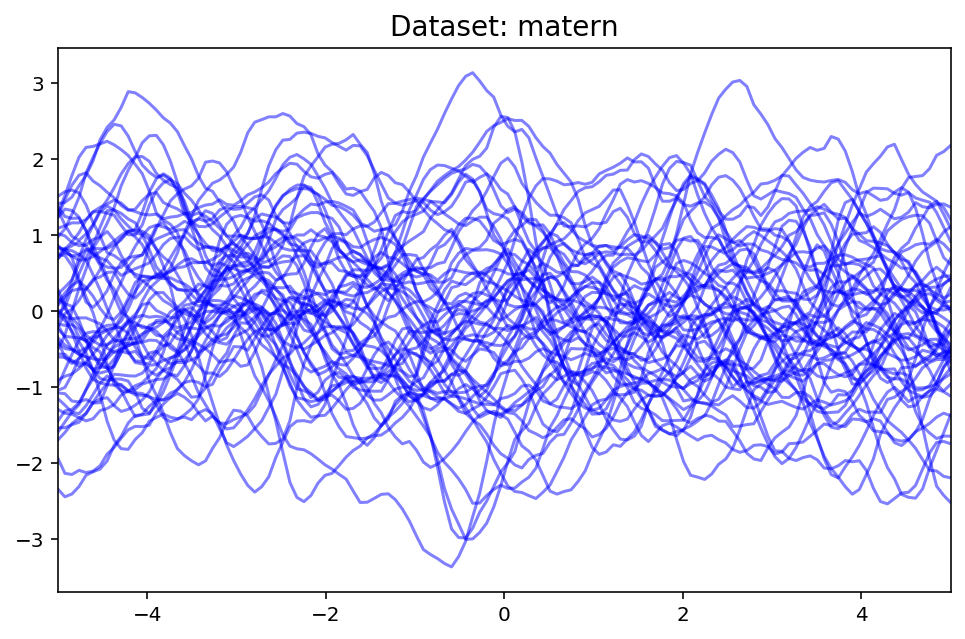

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

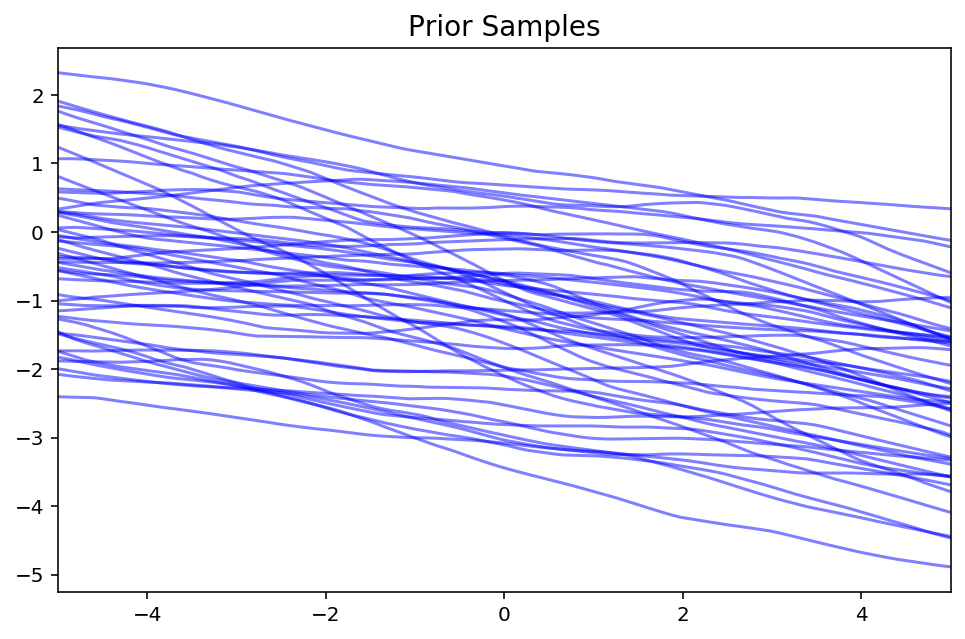

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None)  # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss     dur
-------  ------------  ------
      1      509.9938  3.7641


      2      169.3268  4.0186


      3      157.5933  3.9677


      4      153.1976  3.6225


      5      147.7277  3.8613


      6      139.5442  3.2895


      7      134.1553  3.2267


      8      130.9883  4.1728


      9      127.9193  4.2391


     10      122.3447  4.2477

--- Training periodic ---



  epoch    train_loss     dur
-------  ------------  ------
      1      235.9308  4.4113


      2      141.3652  4.1619


      3      136.2692  4.2388


      4      134.4909  4.1118


      5      134.1784  4.0278


      6      133.1639  3.9412


      7      132.3304  4.1254


      8      131.8046  4.0987


      9      131.4496  4.2386


     10      130.8829  4.2478

--- Training non-stationary ---



  epoch    train_loss     dur
-------  ------------  ------
      1     1307.7581  3.3466


      2      225.1669  4.2839


      3      153.4766  4.3124


      4      124.9753  3.4600


      5      106.9394  3.3571


      6       95.1389  4.2995


      7       83.4385  3.3819


      8       76.2561  3.4662


      9       72.5575  4.3755


     10       62.6576  4.1513

--- Training matern ---



  epoch    train_loss     dur
-------  ------------  ------
      1      225.2025  4.2882


      2      157.9649  3.8964


      3      148.3700  4.0223


      4      144.3220  4.2290


      5      141.5882  4.4868


      6      137.7078  4.7265


      7      133.1403  4.7406


      8      130.5548  4.6679


      9      128.2710  4.5404


     10      125.9819  4.7209


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

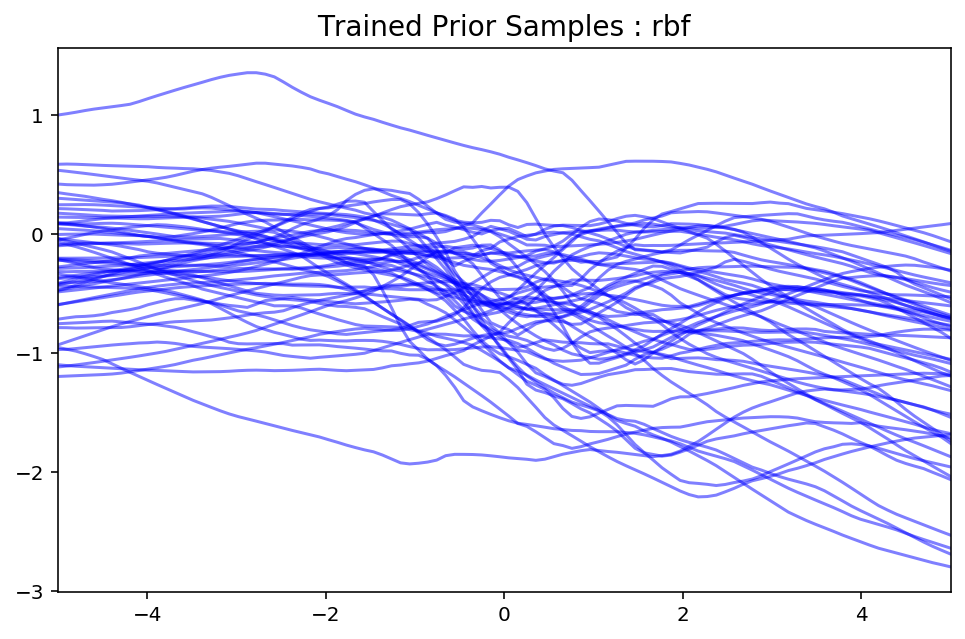

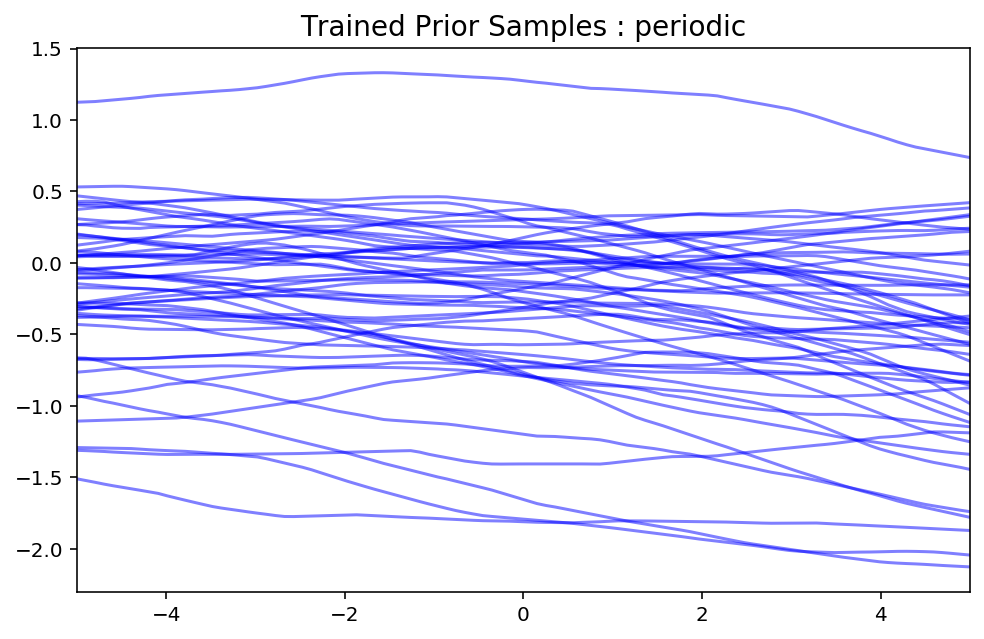

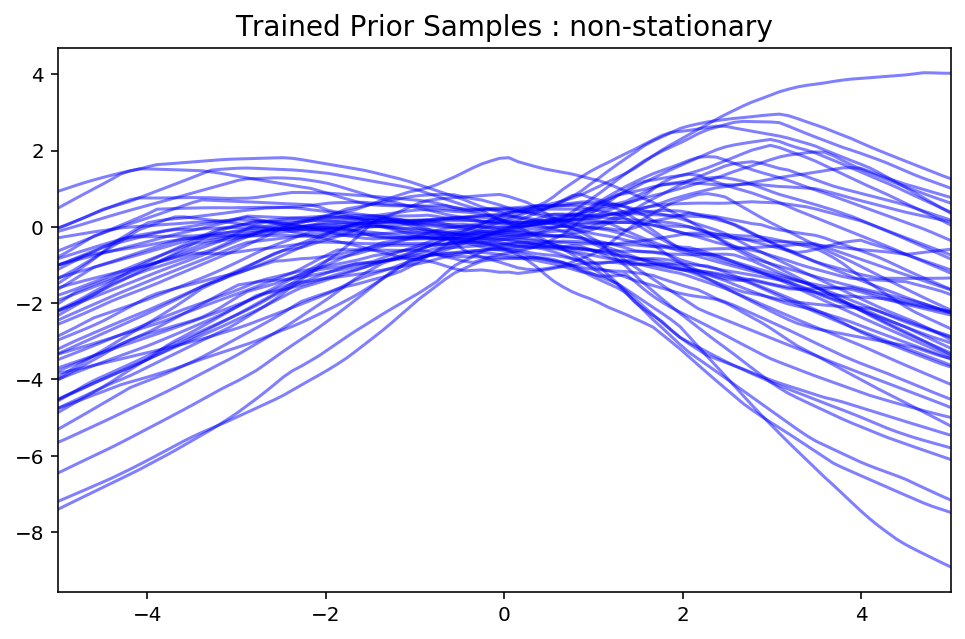

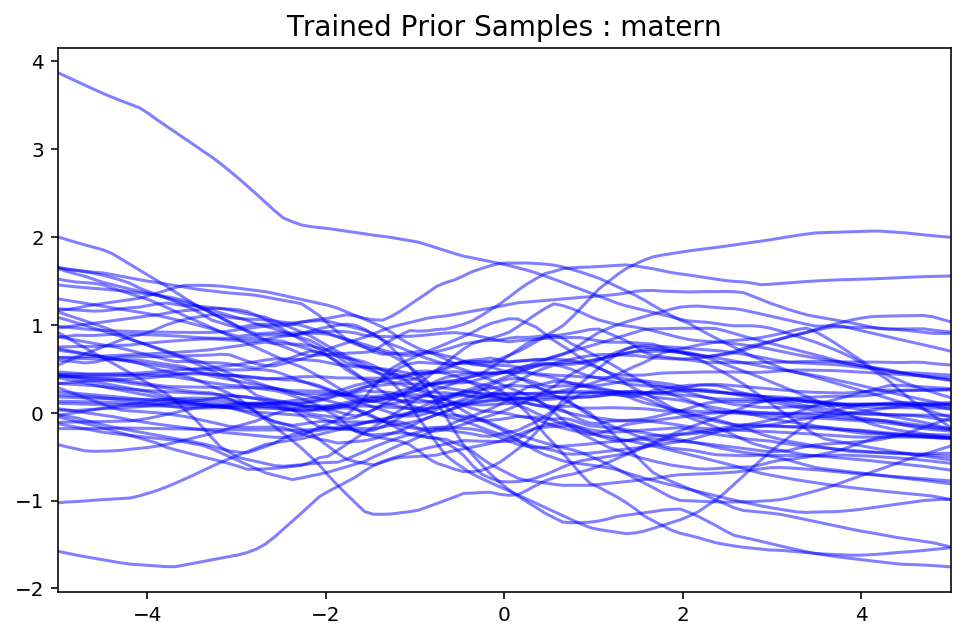

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.8123201
std: 0.8095193
std: 0.3703709
std: 0.59232664


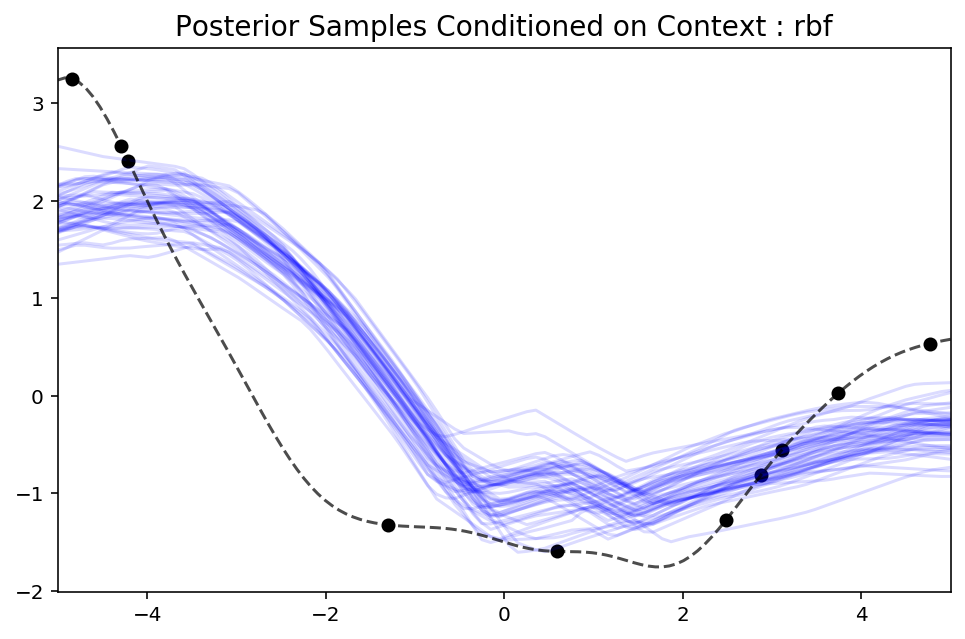

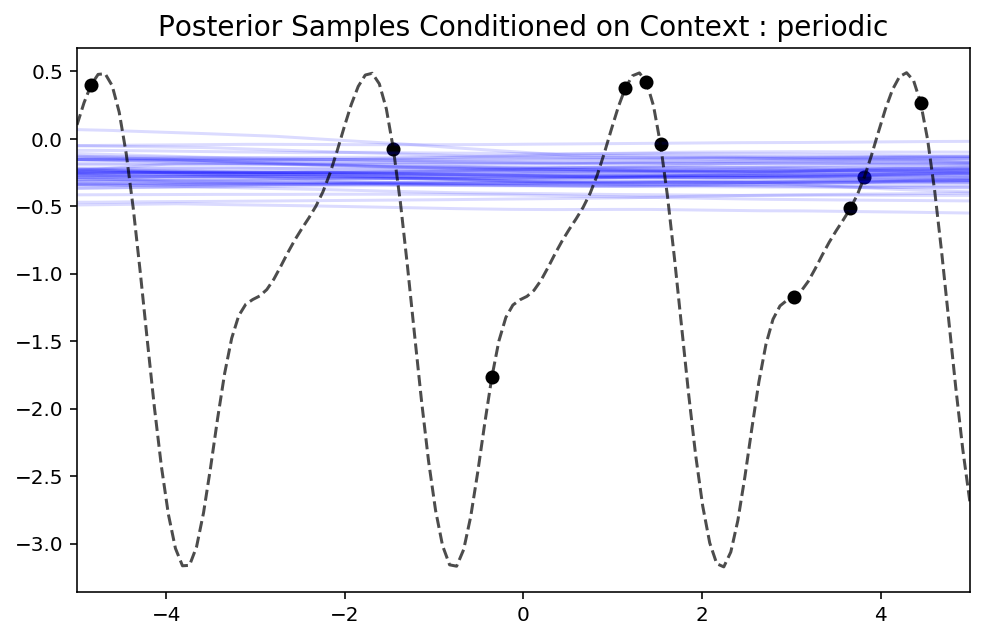

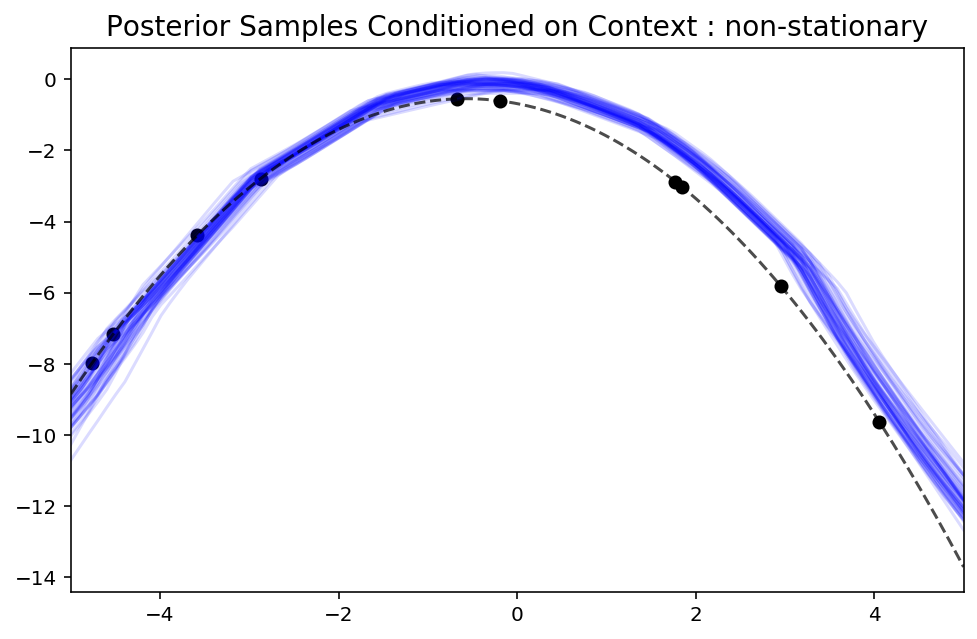

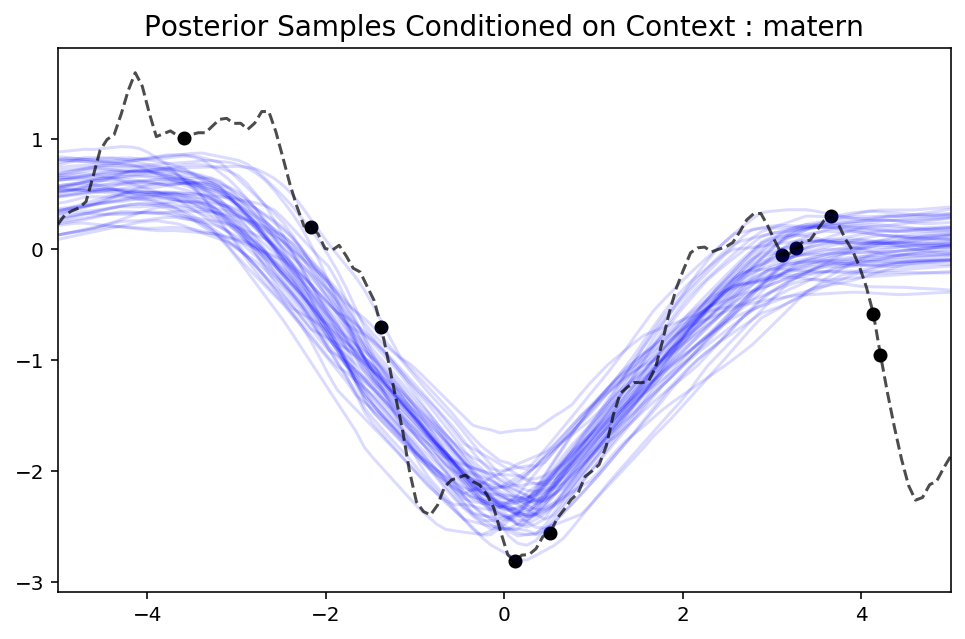

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.57109296
std: 0.37187326
std: 0.40082654
std: 0.525816


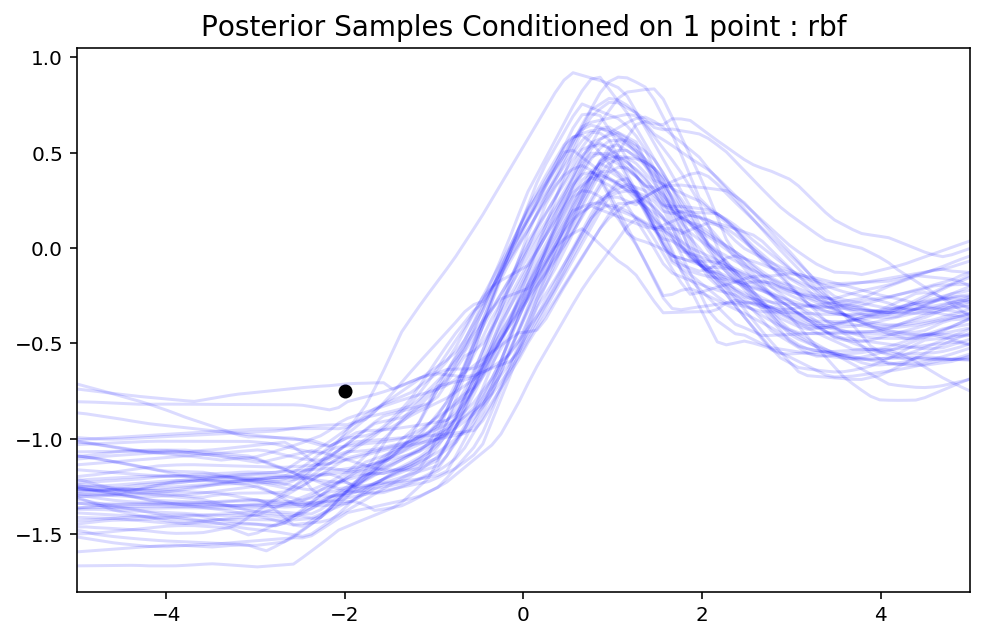

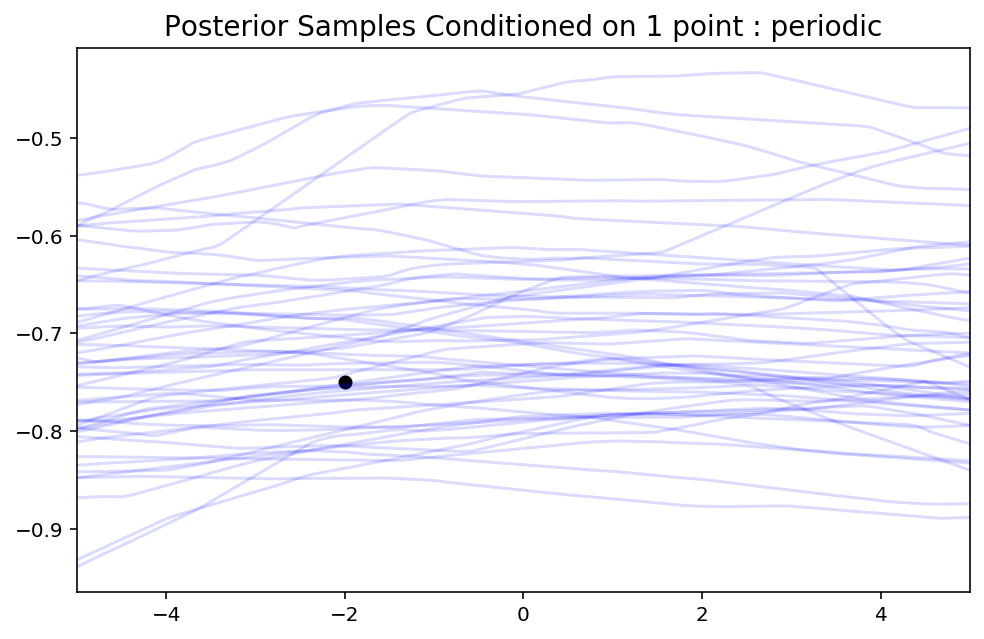

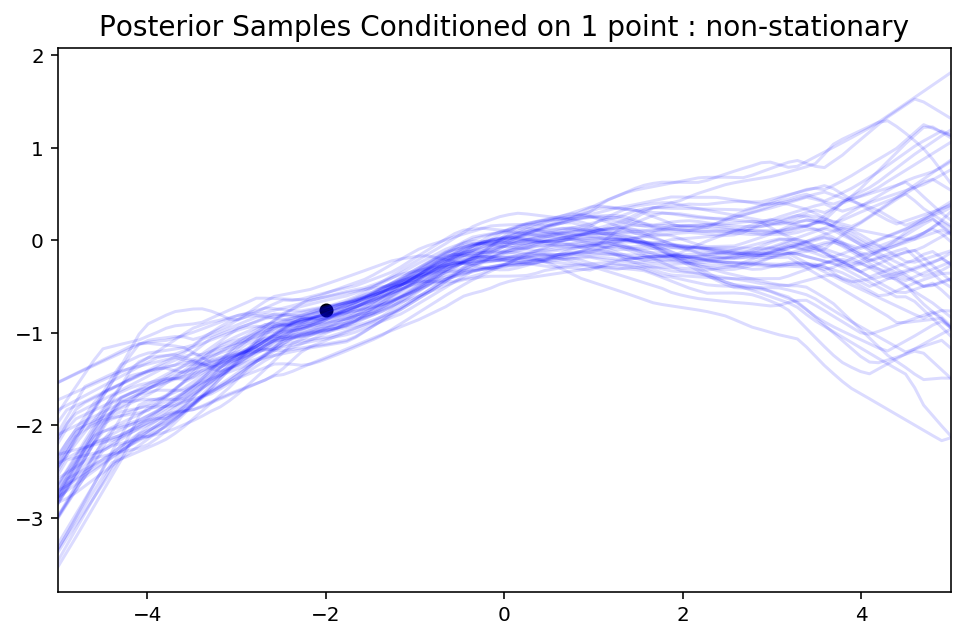

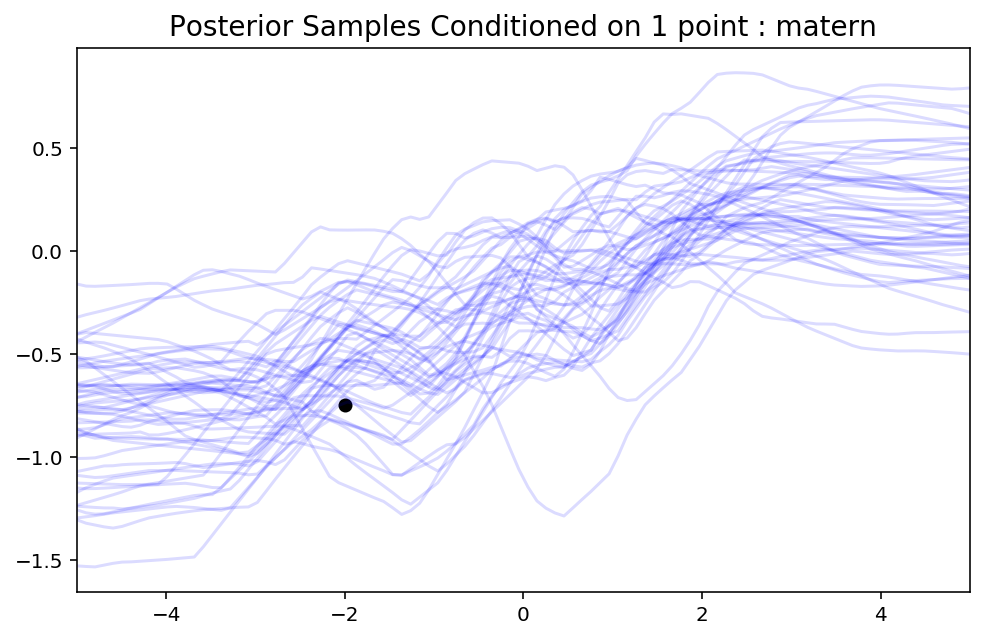

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 0.47042233
std: 0.35614932
std: 0.4868127
std: 0.57615423


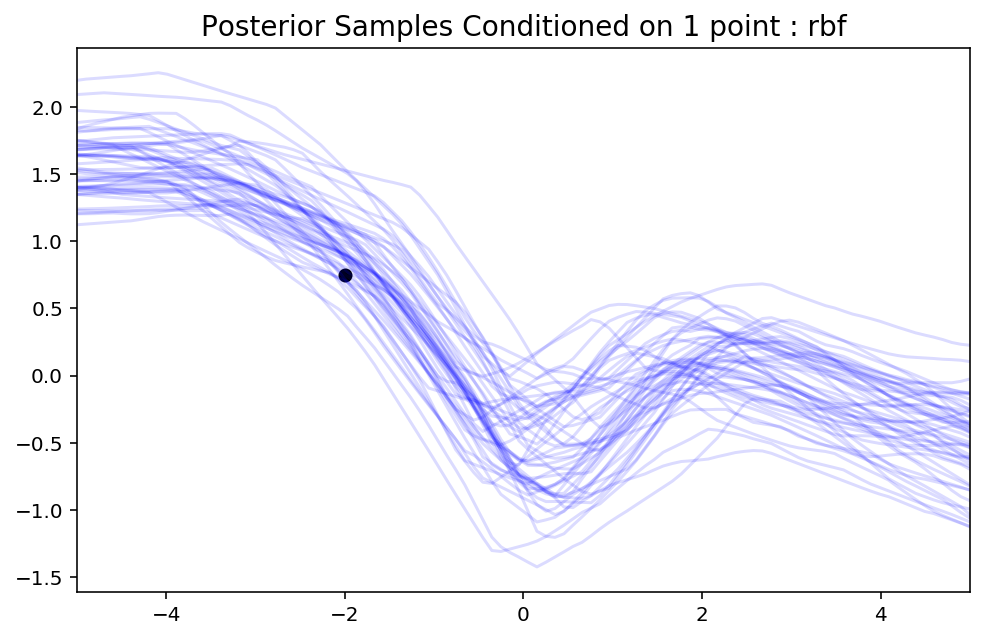

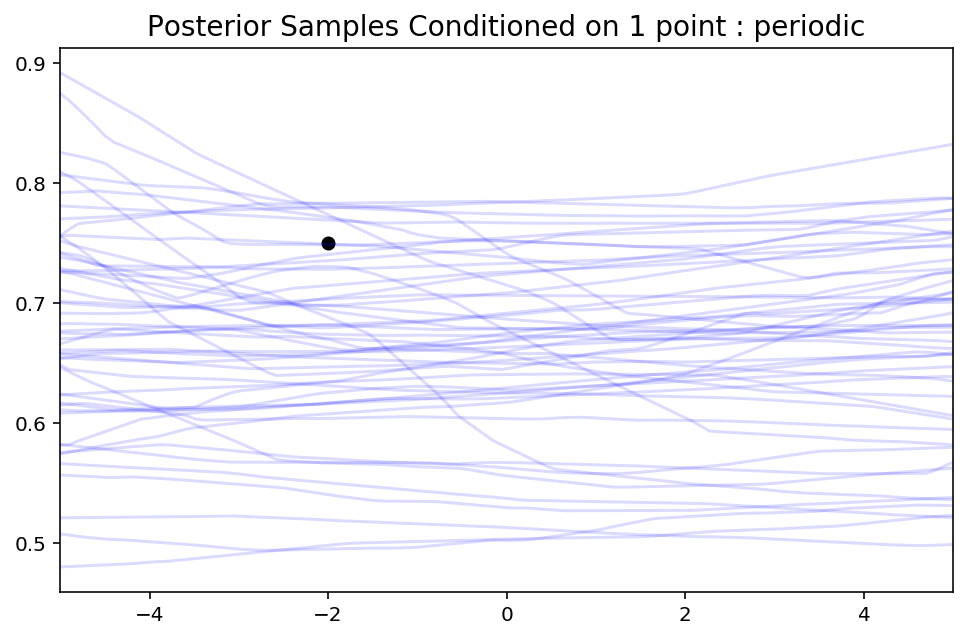

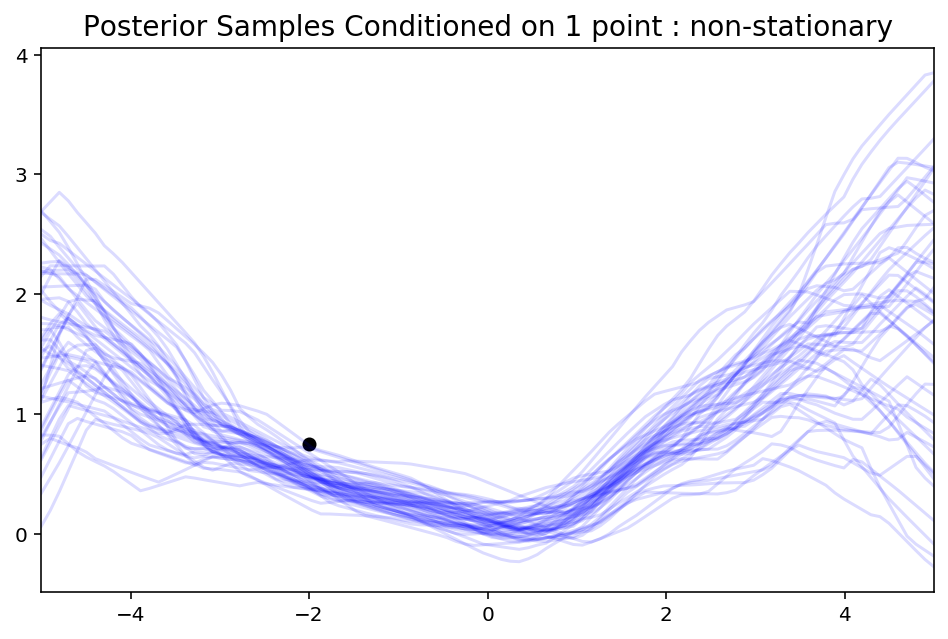

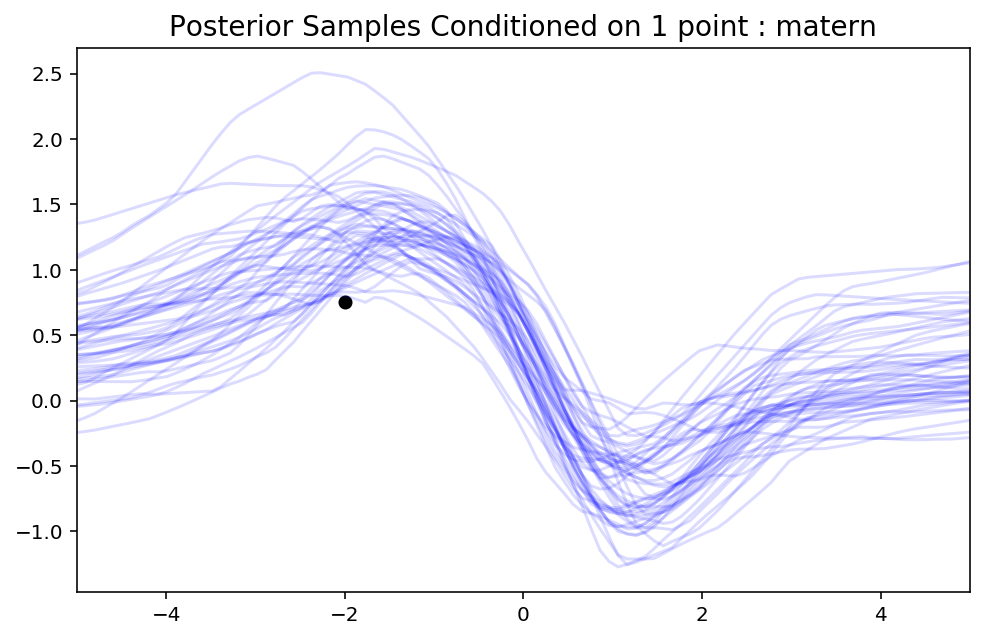

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))